## LIBRERIAS

In [26]:
from flask import Flask, request, jsonify

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.preprocessing import LabelEncoder 
from imblearn.combine import SMOTEENN

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay,
    make_scorer
)

import shap

import joblib

from scipy.stats import chi2_contingency
import pyreadstat  

import threading

import pickle

import requests

import json

#Warnings
import warnings
warnings.filterwarnings("ignore")


<span style="font-size:30px; font-weight:bold; color:black;">DATASET</span>


In [2]:
input_folder = "C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/datos"
output_folder = "C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/datos_csv"

# Convierte cada archivo .XPT a CSV
for archivo in os.listdir(input_folder):
    if archivo.endswith('.XPT'):
        ruta_entrada = os.path.join(input_folder, archivo)
        ruta_salida = os.path.join(output_folder, archivo.replace('.XPT', '.csv'))
        
        try:
            df, meta = pyreadstat.read_xport(ruta_entrada, encoding="ISO-8859-1")
            df.to_csv(ruta_salida, index=False)
            print(f'Archivo convertido: {ruta_salida}')
        except UnicodeDecodeError as e:
            print(f"Error de decodificación en el archivo {archivo}: {e}")


Archivo convertido: C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/datos_csv\P_BMX.csv
Archivo convertido: C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/datos_csv\P_BPXO.csv
Archivo convertido: C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/datos_csv\P_DEMO (1).csv
Archivo convertido: C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/datos_csv\P_DR1TOT.csv
Archivo convertido: C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/datos_csv\P_DR2TOT.csv


       SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDRETH1  \
0  109264.0      66.0       2.0       2.0      13.0       NaN       1.0   
1  109266.0      66.0       2.0       2.0      29.0       NaN       5.0   
2  109270.0      66.0       2.0       2.0      11.0       NaN       4.0   
3  109271.0      66.0       2.0       1.0      49.0       NaN       3.0   
4  109273.0      66.0       2.0       1.0      36.0       NaN       3.0   

   RIDRETH3  RIDEXMON  DMDBORN4  ...  BPXOSY3  BPXODI3  BPXOPLS1  BPXOPLS2  \
0       1.0       2.0       1.0  ...    106.0     66.0      94.0      95.0   
1       6.0       2.0       2.0  ...     99.0     52.0      68.0      66.0   
2       4.0       1.0       1.0  ...    127.0     70.0      95.0      98.0   
3       3.0       2.0       1.0  ...    111.0     68.0      73.0      71.0   
4       3.0       2.0       1.0  ...    115.0     68.0      71.0      70.0   

   BPXOPLS3  weight_height_ratio  calories_per_kg  bmi_category  age_group  \
0 

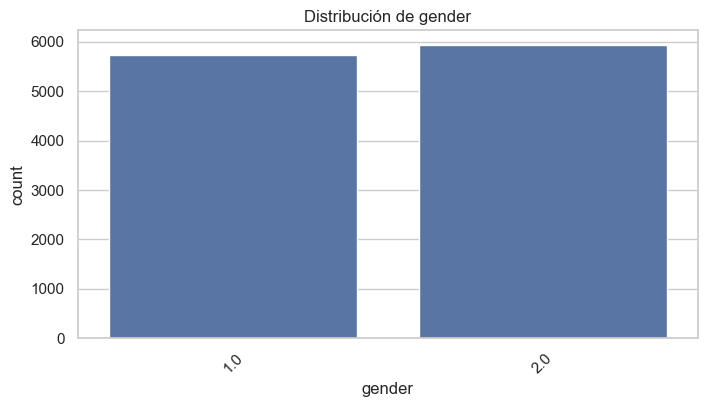

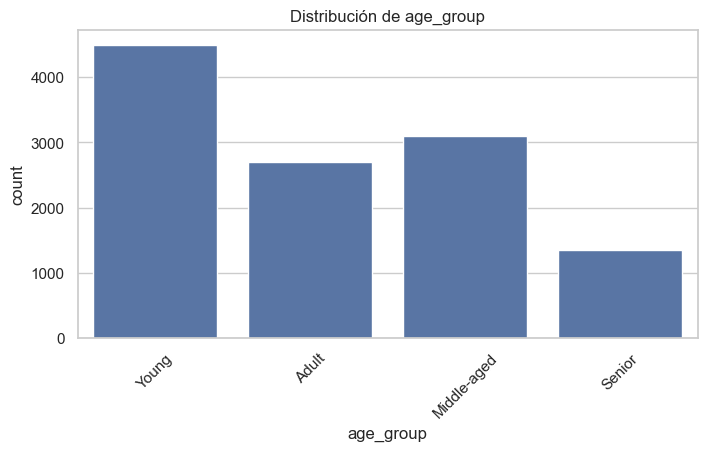

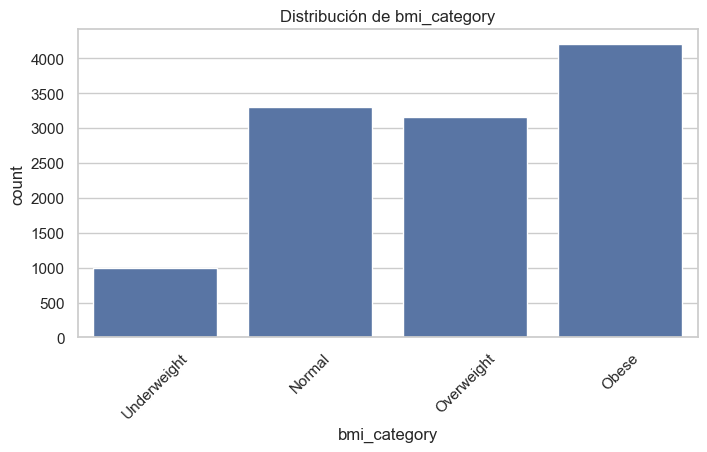

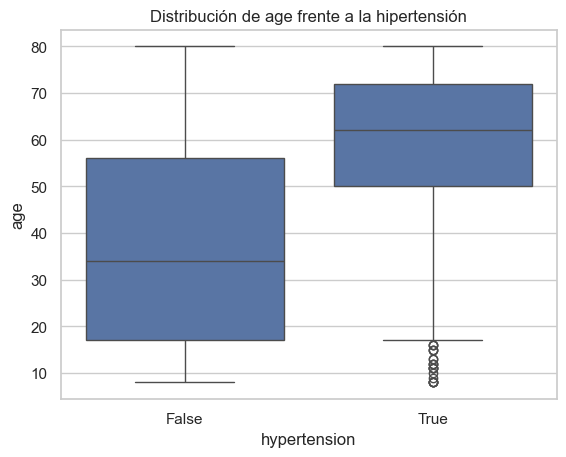

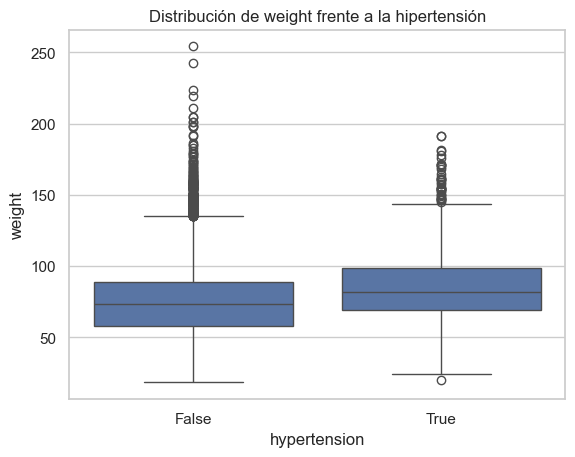

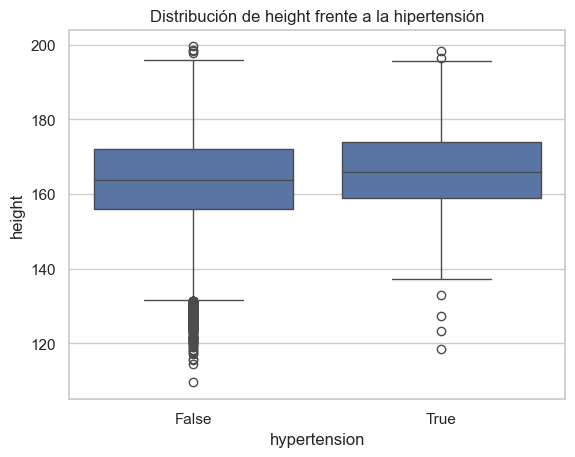

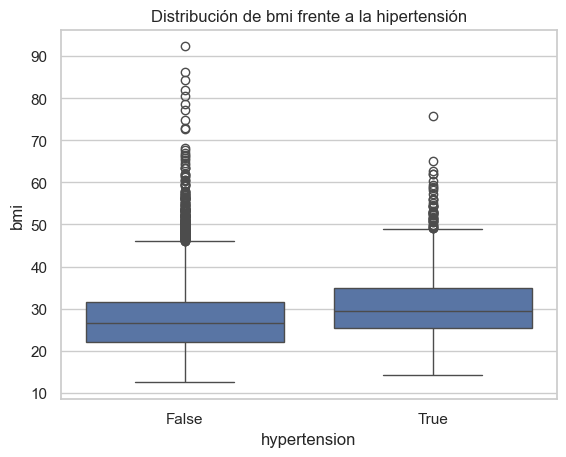

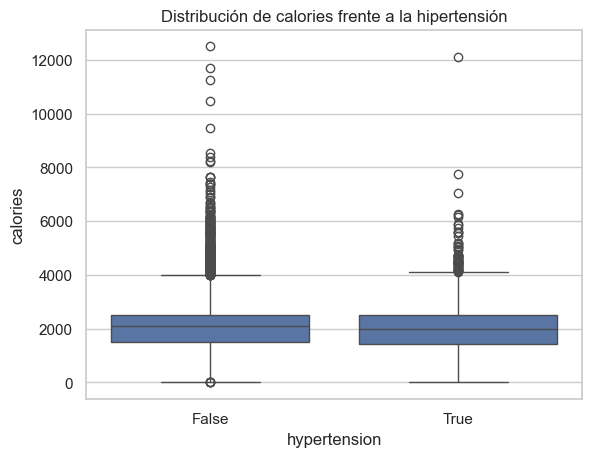

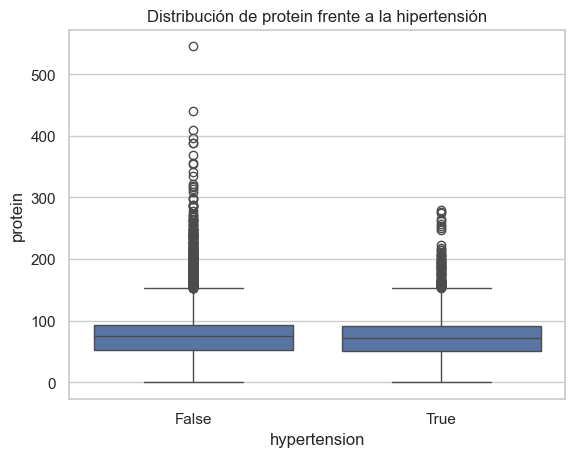

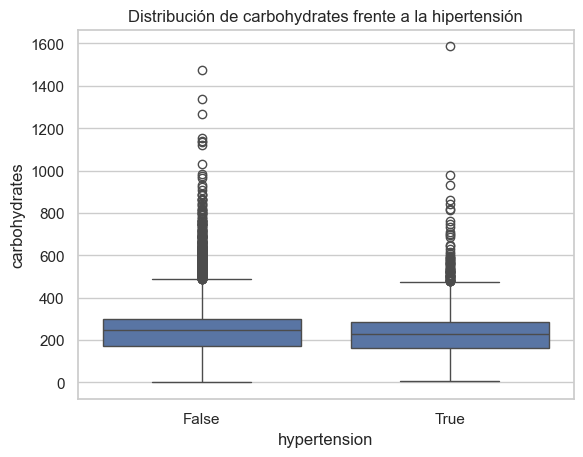

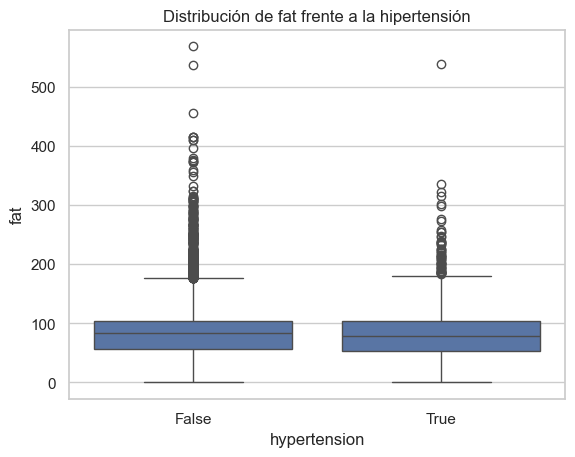

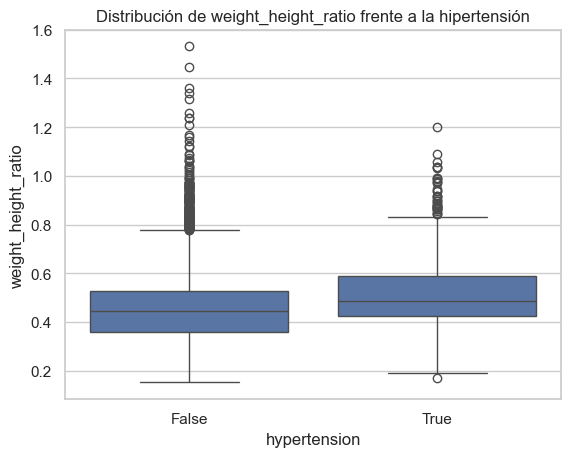

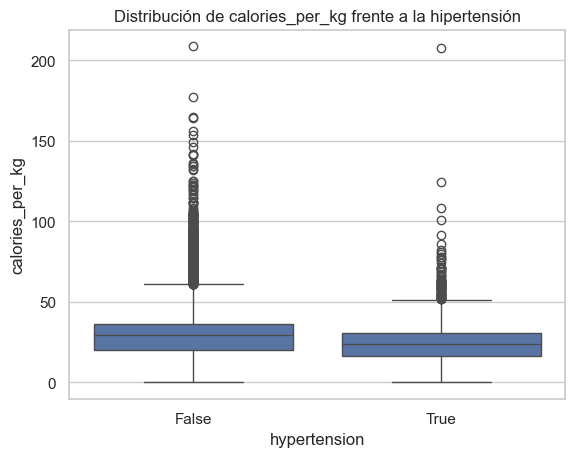

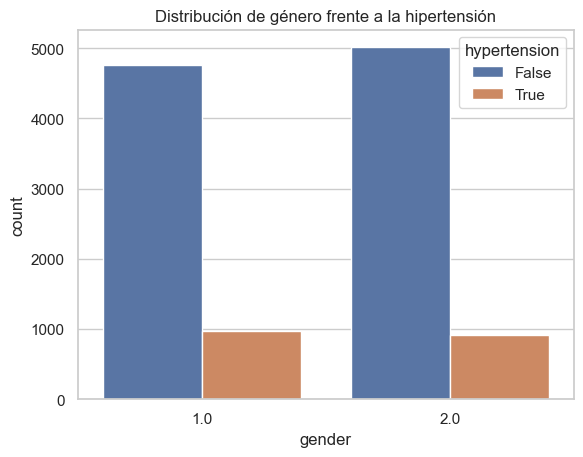

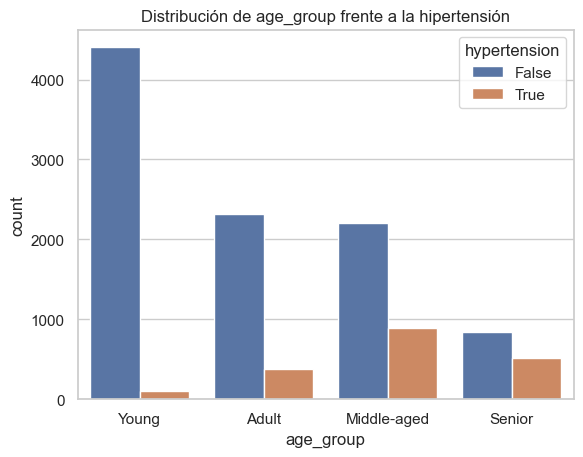

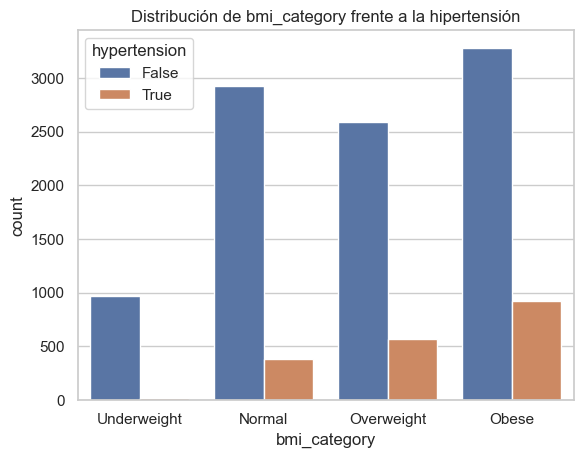

Información de los outliers detectados:
age: {'lower_bound': -44.0, 'upper_bound': 124.0, 'num_outliers': 0}
weight: {'lower_bound': 13.600000000000001, 'upper_bound': 136.79999999999998, 'num_outliers': 241}
height: {'lower_bound': 132.5, 'upper_bound': 196.5, 'num_outliers': 278}
bmi: {'lower_bound': 8.449999999999994, 'upper_bound': 46.45000000000001, 'num_outliers': 307}
calories: {'lower_bound': -36.0, 'upper_bound': 4020.0, 'num_outliers': 466}
protein: {'lower_bound': -9.270000000000003, 'upper_bound': 153.13, 'num_outliers': 515}
carbohydrates: {'lower_bound': -19.062500000000085, 'upper_bound': 487.8975000000001, 'num_outliers': 465}
fat: {'lower_bound': -17.398749999999986, 'upper_bound': 177.05124999999998, 'num_outliers': 480}
weight_height_ratio: {'lower_bound': 0.12142016603231717, 'upper_bound': 0.7861584637608915, 'num_outliers': 290}
calories_per_kg: {'lower_bound': -4.990863661970408, 'upper_bound': 59.52432730144069, 'num_outliers': 713}


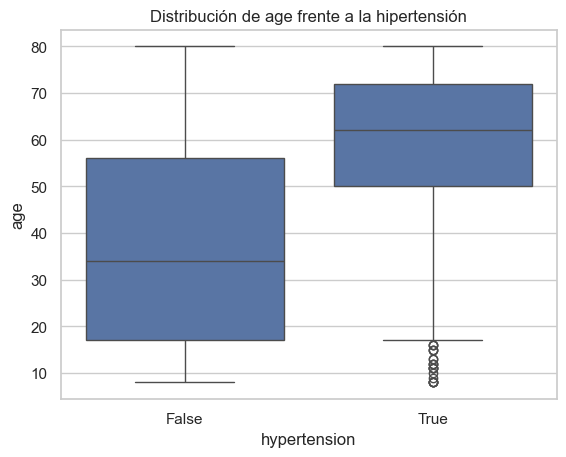

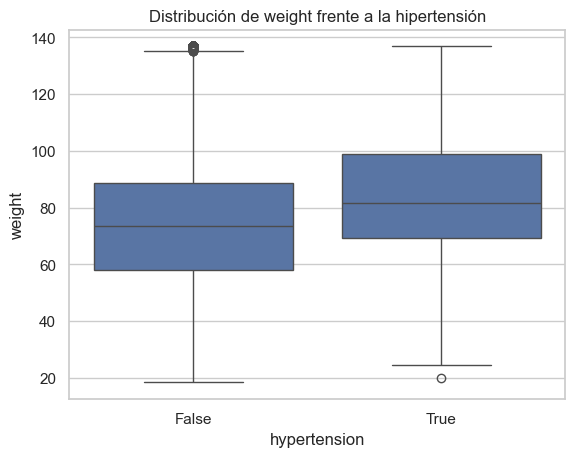

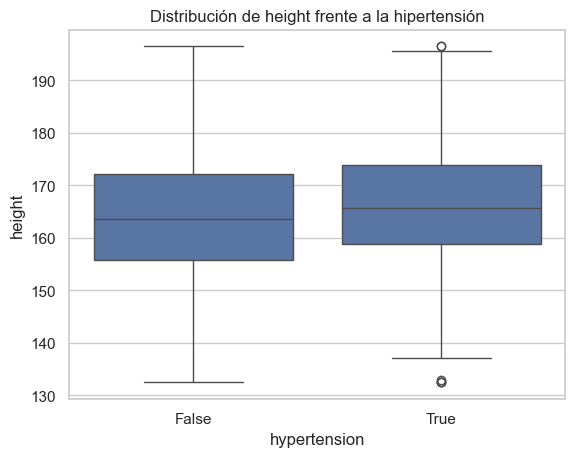

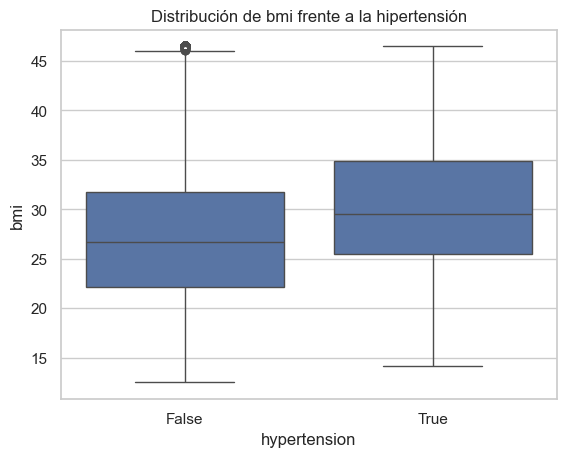

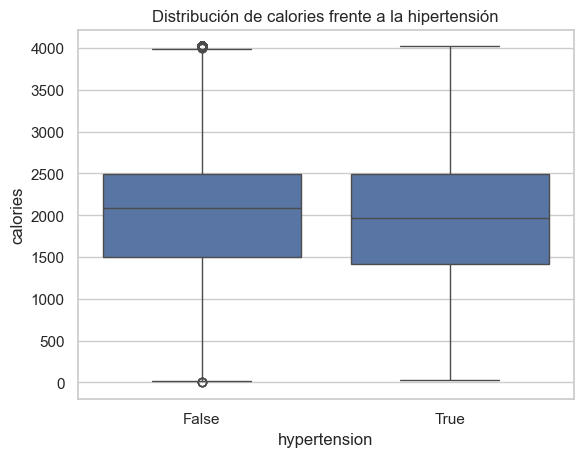

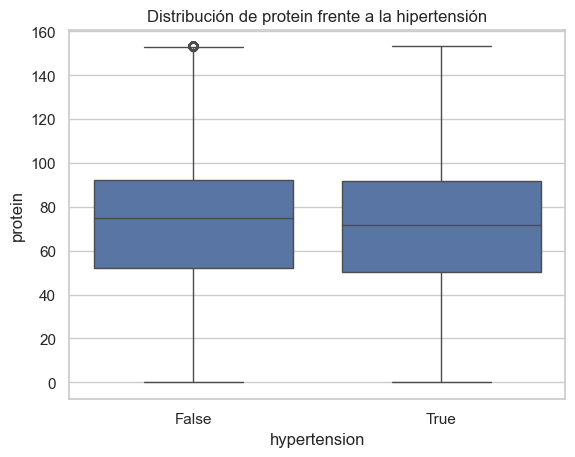

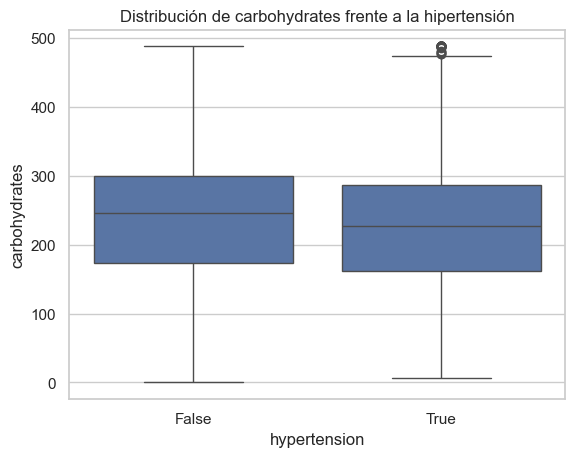

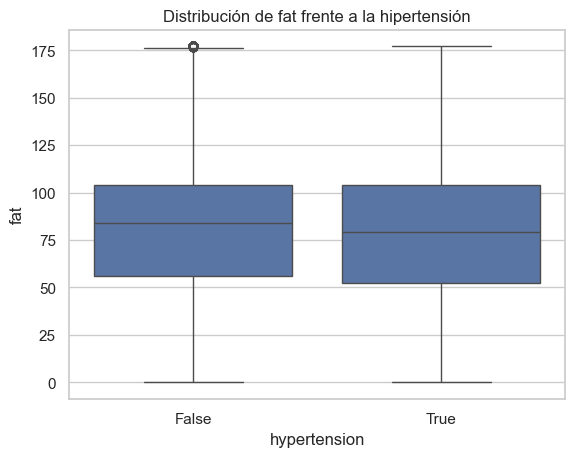

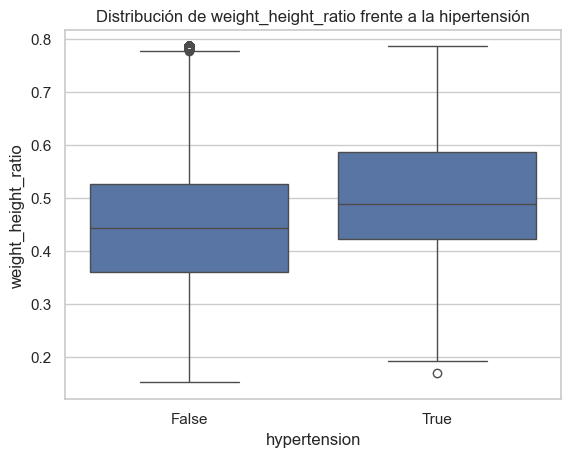

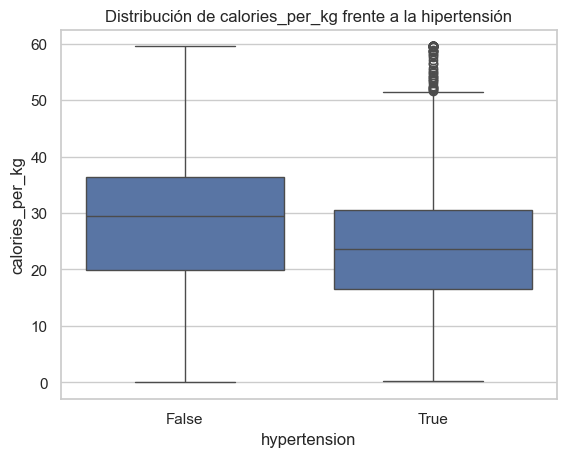

In [5]:
file_path = r"C:\Users\juand\OneDrive\Desktop\Tareas Master\TFM\datos_csv"

sns.set(style="whitegrid")
np.random.seed(6884)
# Cargar los archivos
demographics = pd.read_csv(f"{file_path}\P_DEMO (1).csv")
dietary_day1 = pd.read_csv(f"{file_path}\P_DR1TOT.csv")
dietary_day2 = pd.read_csv(f"{file_path}\P_DR2TOT.csv")
bmi = pd.read_csv(f"{file_path}\P_BMX.csv")
blood_pressure = pd.read_csv(f"{file_path}\P_BPXO.csv")

#Combinar dataframes
combined_data = pd.merge(demographics, dietary_day1, on='SEQN', how='inner')
combined_data = pd.merge(combined_data, dietary_day2, on='SEQN', how='inner')
combined_data = pd.merge(combined_data, bmi, on='SEQN', how='inner')
combined_data = pd.merge(combined_data, blood_pressure, on='SEQN', how='inner')

# Características adicionales
combined_data['weight_height_ratio'] = combined_data['BMXWT'] / combined_data['BMXHT']
combined_data['calories_per_kg'] = combined_data['DR1TKCAL'] / combined_data['BMXWT']

# Crear variables categóricas
combined_data['bmi_category'] = pd.cut(combined_data['BMXBMI'], 
                                       bins=[0, 18.5, 24.9, 29.9, 100], 
                                       labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

combined_data['age_group'] = pd.cut(combined_data['RIDAGEYR'], 
                                    bins=[0, 30, 50, 70, 100], 
                                    labels=['Young', 'Adult', 'Middle-aged', 'Senior'])


#Variable objetivo
combined_data['hypertension'] = (combined_data['BPXOSY1'] > 139) | (combined_data['BPXODI1'] > 89)

print(combined_data.head())

# Variables categóricas
categorical_columns = combined_data.select_dtypes(include=['object', 'category']).columns
print("Variables categóricas:", list(categorical_columns))

# Variables numéricas
numerical_columns = combined_data.select_dtypes(include=['int64', 'float64']).columns
print("Variables numéricas:", list(numerical_columns))

# Variables que deberían ser categóricas
categorical_vars = ['RIAGENDR', 'RIDRETH1', 'RIDRETH3', 'SDDSRVYR', 
                    'RIDSTATR', 'RIDEXMON', 'DMDBORN4', 'DR1LANG', 'DR2LANG', 
                    'DRABF_x', 'DRABF_y','bmi_category','age_group']

# Convertir a categóricas
for var in categorical_vars:
    if var in combined_data.columns:
        combined_data[var] = combined_data[var].astype('category')

print("Variables categóricas después de la conversión:")
print(combined_data[categorical_vars].dtypes)

# Definir las columnas numéricas
numerical_vars = combined_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Se imputan los valores numéricos con la media
for var in numerical_vars:
    if var in combined_data.columns:
        combined_data[var].fillna(combined_data[var].mean(), inplace=True)

null_values = combined_data.isnull().sum()

print("Valores nulos por variable:")
print(null_values[null_values > 0])

# Eliminar columnas completamente nulas
columns_to_drop = ['RIDAGEMN', 'BMXRECUM', 'BMIRECUM', 'BMXHEAD', 'BMIHEAD']
combined_data.drop(columns=columns_to_drop, inplace=True)

# Imputar variables categóricas con la moda
categorical_impute = ['DRABF_x', 'DRABF_y', 'DR1LANG', 'DR2LANG', 'BPAOARM','bmi_category']
for col in categorical_impute:
    if col in combined_data.columns:
        combined_data[col].fillna(combined_data[col].mode()[0], inplace=True)

print("Valores nulos después del tratamiento:")
print(combined_data.isnull().sum())


# Variables de interés
columns_of_interest = ['RIAGENDR', 'RIDAGEYR', 'BMXWT', 'BMXHT', 'BMXBMI', 
                       'DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TTFAT', 'weight_height_ratio', 
                       'calories_per_kg', 'hypertension','age_group','bmi_category']

new_column_names = ['gender', 'age', 'weight', 'height', 'bmi', 
                    'calories', 'protein', 'carbohydrates', 'fat', 'weight_height_ratio', 
                    'calories_per_kg', 'hypertension','age_group','bmi_category']

data = combined_data[columns_of_interest].copy()

rename_dict = dict(zip(columns_of_interest, new_column_names))

data.rename(columns=rename_dict, inplace=True)

# Variables categóricas
categorical_columns = data.select_dtypes(include=['object', 'category']).columns
print("Variables categóricas:", list(categorical_columns))

# Variables numéricas
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
print("Variables numéricas:", list(numerical_columns))

# Descripción de variables
print("Descripción estadística de las variables:")
print(data.describe())

for var in categorical_columns:
    if var in data.columns:
        print(f"Distribución de {var}:")
        print(data[var].value_counts())
        print("\n")

for var in categorical_columns:
    if var in data.columns:
        plt.figure(figsize=(8, 4))
        sns.countplot(data=data, x=var)
        plt.title(f"Distribución de {var}")
        plt.xticks(rotation=45)
        plt.show()

# Distribución de variables numéricas frente a la variable objetivo
for col in numerical_columns:
    sns.boxplot(data=data, x='hypertension', y=col)
    plt.title(f"Distribución de {col} frente a la hipertensión")
    plt.show()

# Distribución de variables categóricas frente a la variable objetivo
sns.countplot(data=data, x='gender', hue='hypertension')
plt.title("Distribución de género frente a la hipertensión")
plt.show()

sns.countplot(data=data, x='age_group', hue='hypertension')
plt.title("Distribución de age_group frente a la hipertensión")
plt.show()

sns.countplot(data=data, x='bmi_category', hue='hypertension')
plt.title("Distribución de bmi_category frente a la hipertensión")
plt.show()

# Identificar outliers usando IQR
def identify_outliers_iqr(df, columns):
    outliers_info = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_info[col] = {
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'num_outliers': len(outliers)
        }
    return outliers_info

# Tratar los outliers reemplazándolos
def handle_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

outliers_info = identify_outliers_iqr(data, numerical_columns)

print("Información de los outliers detectados:")
for col, info in outliers_info.items():
    print(f"{col}: {info}")

data = handle_outliers_iqr(data, numerical_columns)

# Verificar la distribución después del tratamiento
for col in numerical_columns:
    sns.boxplot(data=data, x='hypertension', y=col)
    plt.title(f"Distribución de {col} frente a la hipertensión")
    plt.show()




Cramer's V para gender frente a 'hypertension': 0.0174
Cramer's V para age_group frente a 'hypertension': 0.3576
Cramer's V para bmi_category frente a 'hypertension': 0.1619


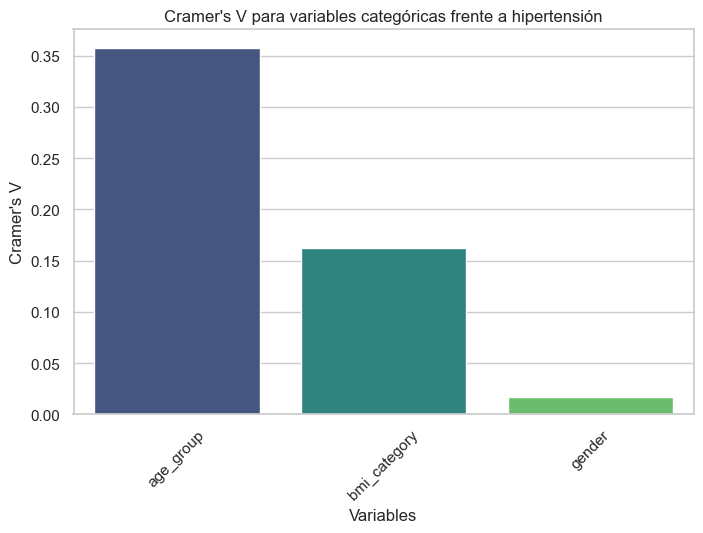

In [6]:
# Función para calcular V de Cramer
def cramers_v(contingency_table):
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - (((k - 1) * (r - 1)) / (n - 1)))
    rcorr = r - (((r - 1) ** 2) / (n - 1))
    kcorr = k - (((k - 1) ** 2) / (n - 1))
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

categorical_vars = ['gender', 'age_group', 'bmi_category']

cramer_values = {}

# Calcular V de Cramer para cada variable categórica frente a hypertension
for var in categorical_vars:
    contingency_table = pd.crosstab(data[var], data['hypertension'])
    cv = cramers_v(contingency_table)
    cramer_values[var] = cv
    print(f"Cramer's V para {var} frente a 'hypertension': {cv:.4f}")

df_cramer = pd.DataFrame(list(cramer_values.items()), columns=['Variable', "Cramer's V"])
df_cramer = df_cramer.sort_values(by="Cramer's V", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=df_cramer, x='Variable', y="Cramer's V", palette='viridis')
plt.title("Cramer's V para variables categóricas frente a hipertensión")
plt.ylabel("Cramer's V")
plt.xlabel("Variables")
plt.xticks(rotation=45)
plt.show()


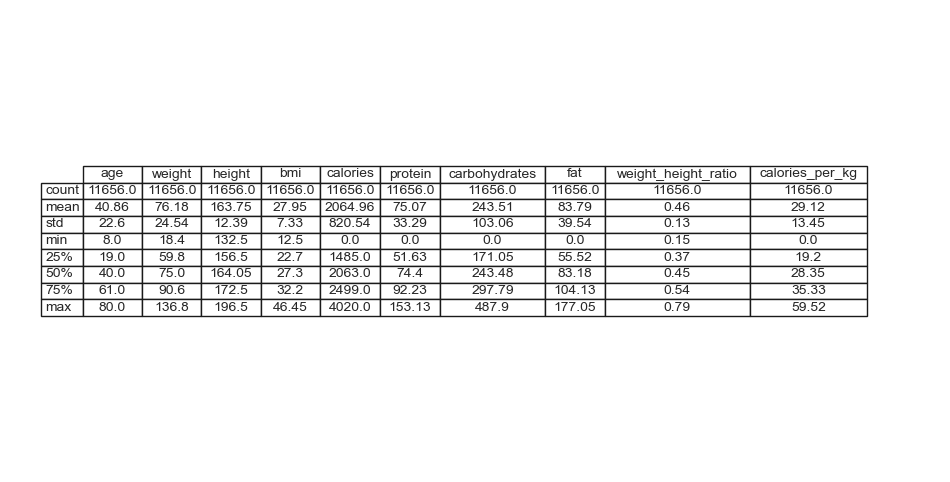

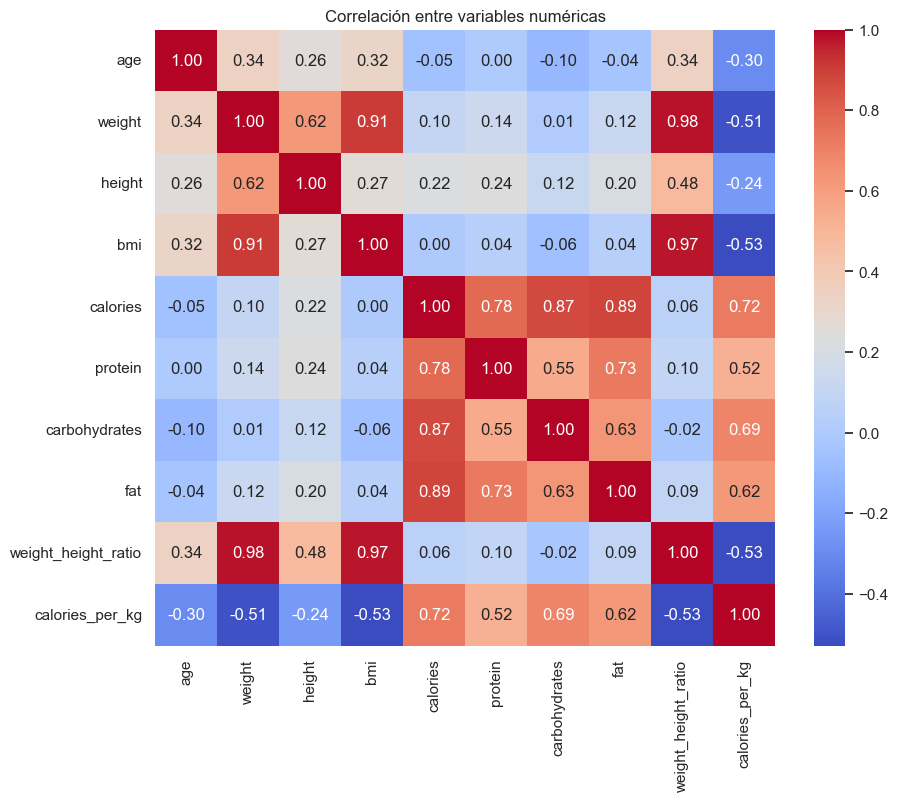

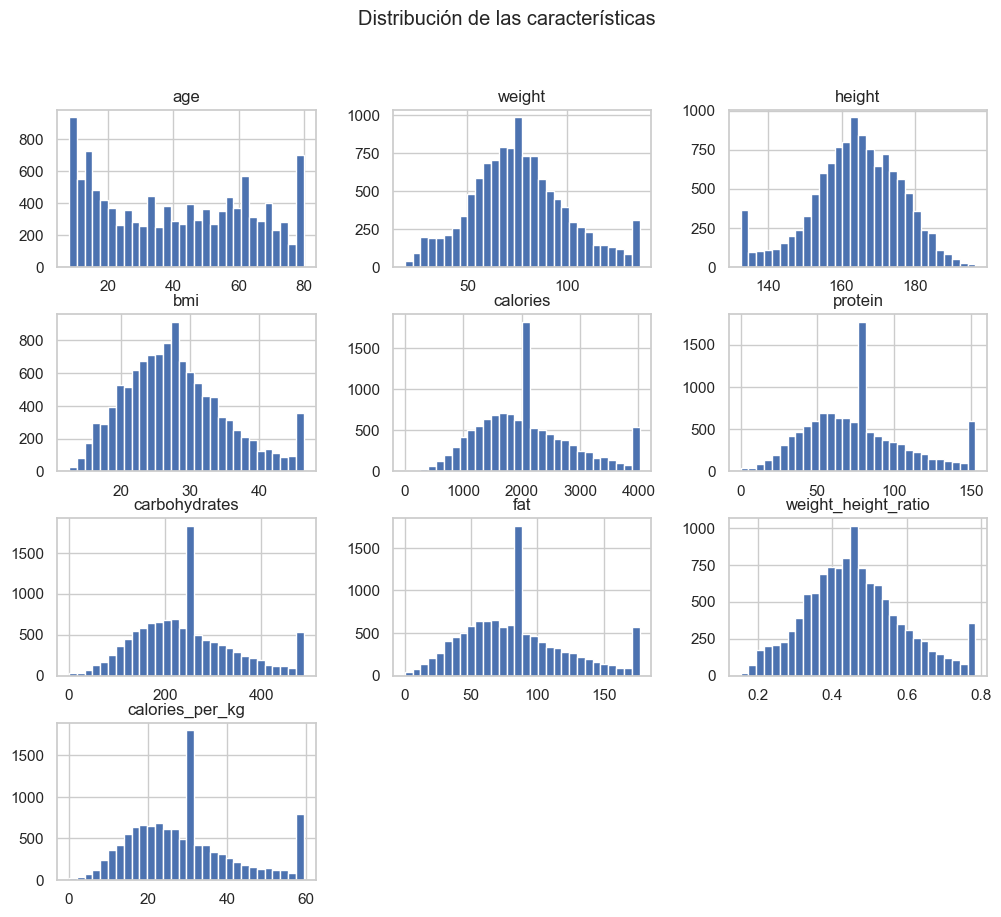

Scaler guardado en: C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/modelos_guardados/scaler.joblib
Encoders guardados correctamente.
Tamaño de X_train: (8159, 13)
Tamaño de X_test: (3497, 13)
Tamaño de y_train: (8159,)
Tamaño de y_test: (3497,)


In [7]:
X = data.drop(['hypertension'], axis=1).copy() 
y = data['hypertension']  # Variable objetivo

descripcion_estadistica = data.describe()

# Crear una figura para la tabla
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')

tabla = plt.table(
    cellText=descripcion_estadistica.round(2).values,
    colLabels=descripcion_estadistica.columns,
    rowLabels=descripcion_estadistica.index,
    loc='center',
    cellLoc='center'
)

tabla.auto_set_font_size(False)
tabla.set_fontsize(10)

tabla.auto_set_column_width(col=list(range(len(descripcion_estadistica.columns))))

plt.savefig("descripcion_estadistica.png", bbox_inches='tight')
plt.show()

numeric_data = data.select_dtypes(include=['number'])

# Visualización de correlaciones entre las variables numéricas
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlación entre variables numéricas")
plt.show()

# Histogramas de variables numéricas
data.hist(figsize=(12, 10), bins=30)
plt.suptitle("Distribución de las características")
plt.show()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaled_columns = ['weight', 'height', 'bmi', 'calories', 'protein', 'carbohydrates', 'fat','weight_height_ratio','calories_per_kg',]
X[scaled_columns] = scaler.fit_transform(X[scaled_columns])

scaler_path = "C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/modelos_guardados/scaler.joblib"
joblib.dump(scaler, scaler_path)
print(f"Scaler guardado en: {scaler_path}")

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6884, stratify=y)

gender_encoder = LabelEncoder()
age_group_encoder = LabelEncoder()
bmi_category_encoder = LabelEncoder()

# Aplicar el encoding en X_train y X_test
X_train['gender'] = gender_encoder.fit_transform(X_train['gender'])
X_test['gender'] = gender_encoder.transform(X_test['gender'])
X_train['age_group'] = age_group_encoder.fit_transform(X_train['age_group'])
X_test['age_group'] = age_group_encoder.transform(X_test['age_group'])
X_train['bmi_category'] = bmi_category_encoder.fit_transform(X_train['bmi_category'])
X_test['bmi_category'] = bmi_category_encoder.transform(X_test['bmi_category'])

joblib.dump(gender_encoder, "C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/encoders/gender_encoder.joblib")
joblib.dump(age_group_encoder, "C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/encoders/age_group_encoder.joblib")
joblib.dump(bmi_category_encoder, "C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/encoders/bmi_category_encoder.joblib")

print("Encoders guardados correctamente.")

print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}")
print(f"Tamaño de y_train: {y_train.shape}")
print(f"Tamaño de y_test: {y_test.shape}")

Distribución de clases en el conjunto de entrenamiento:
hypertension
False    6839
True     1320
Name: count, dtype: int64

Proporción de clases:
hypertension
False    0.838215
True     0.161785
Name: count, dtype: float64


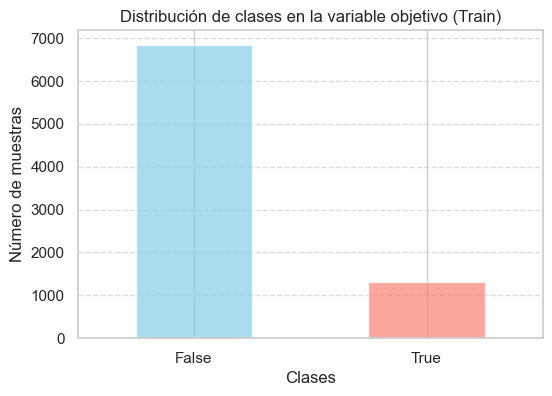

Distribución después de SMOTE:
hypertension
True     4609
False    4189
Name: count, dtype: int64
Distribución de clases en el conjunto de entrenamiento:
hypertension
True     4609
False    4189
Name: count, dtype: int64

Proporción de clases:
hypertension
True     0.523869
False    0.476131
Name: count, dtype: float64


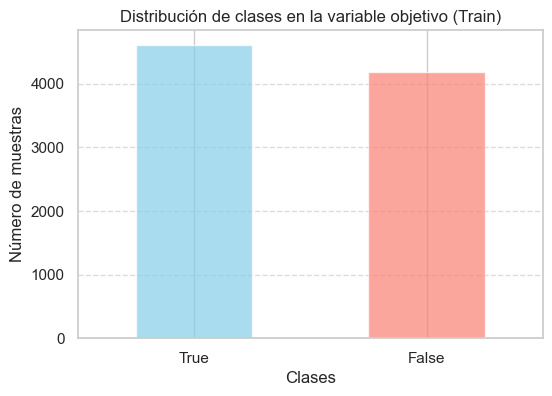

In [8]:
class_counts = y_train.value_counts()

# Mostrar las proporciones de las clases
print("Distribución de clases en el conjunto de entrenamiento:")
print(class_counts)

proporciones = class_counts / len(y_train)
print("\nProporción de clases:")
print(proporciones)

plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['skyblue', 'salmon'], alpha=0.7)
plt.title("Distribución de clases en la variable objetivo (Train)")
plt.xlabel("Clases")
plt.ylabel("Número de muestras")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



smote_enn = SMOTEENN(sampling_strategy=0.8, random_state=6884)
X_train, y_train = smote_enn.fit_resample(X_train, y_train)


# Verificar la distribución
print("Distribución después de SMOTE:")
print(y_train.value_counts())

class_counts = y_train.value_counts()

print("Distribución de clases en el conjunto de entrenamiento:")
print(class_counts)

proporciones = class_counts / len(y_train)
print("\nProporción de clases:")
print(proporciones)

plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['skyblue', 'salmon'], alpha=0.7)
plt.title("Distribución de clases en la variable objetivo (Train)")
plt.xlabel("Clases")
plt.ylabel("Número de muestras")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<span style="font-size:30px; font-weight:bold; color:black;">REGRESIÓN LOGÍSTICA</span>

Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.96      0.61      0.75      2931
        True       0.30      0.86      0.45       566

    accuracy                           0.65      3497
   macro avg       0.63      0.74      0.60      3497
weighted avg       0.85      0.65      0.70      3497


Matriz de confusión:
[[1789 1142]
 [  77  489]]


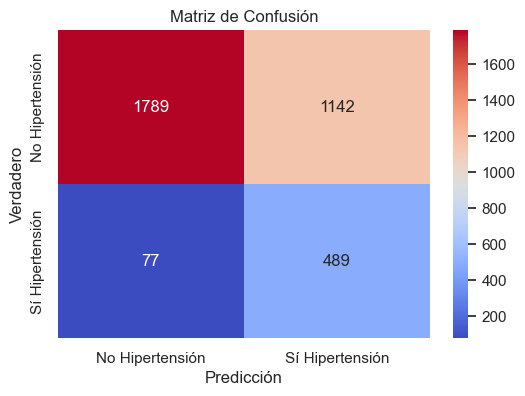


AUC-ROC: 0.7805


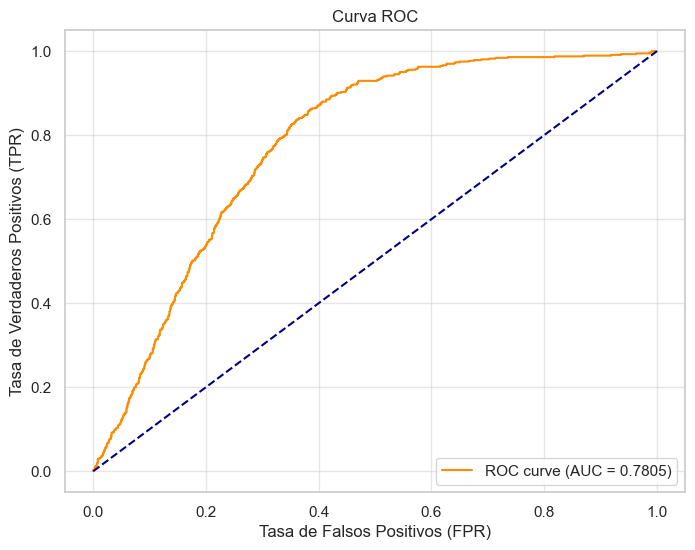


Exactitud del modelo: 0.6514


In [5]:
modelo1 = LogisticRegression(class_weight='balanced',random_state=6884, max_iter=2000)

# Entrenar el modelo
modelo1.fit(X_train, y_train)

# Realizar predicciones
y_pred = modelo1.predict(X_test)
y_pred_prob = modelo1.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva

# Evaluación del modelo
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

print("\nMatriz de confusión:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

#Matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=["No Hipertensión", "Sí Hipertensión"], yticklabels=["No Hipertensión", "Sí Hipertensión"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.show()

roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC-ROC: {roc_auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})", color="darkorange")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.title("Curva ROC")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.5)
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print(f"\nExactitud del modelo: {accuracy:.4f}")

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logreg = LogisticRegression(class_weight='balanced',max_iter=2000, solver='lbfgs', random_state=6884)

# Variables iniciales
variables_seleccionadas = []
variables_disponibles = list(X_train.columns)

mejor_score = 0

print("Inicio del proceso de selección Stepwise...\n")

# Stepwise
while True:
    scores_agregar = []
    candidatos_agregar = []
    
    for variable in variables_disponibles:
        variables_propuestas = variables_seleccionadas + [variable]
        X_propuesto = X_train[variables_propuestas]
        
        if not X_propuesto.empty:
            score = cross_val_score(logreg, X_propuesto, y_train, cv=5, scoring='accuracy').mean()
            scores_agregar.append(score)
            candidatos_agregar.append(variable)
    
    # Seleccionar la mejor variable para agregar
    if scores_agregar:
        mejor_score_agregar = max(scores_agregar)
        mejor_variable_agregar = candidatos_agregar[scores_agregar.index(mejor_score_agregar)]
    else:
        mejor_score_agregar = 0
        mejor_variable_agregar = None

    # Eliminar variables
    scores_eliminar = []
    candidatos_eliminar = []
    
    for variable in variables_seleccionadas:
        variables_propuestas = [v for v in variables_seleccionadas if v != variable]
        X_propuesto = X_train[variables_propuestas]
        
        if not X_propuesto.empty:
            score = cross_val_score(logreg, X_propuesto, y_train, cv=5, scoring='accuracy').mean()
            scores_eliminar.append(score)
            candidatos_eliminar.append(variable)
    
    # Seleccionar la mejor variable para eliminar
    if scores_eliminar:
        mejor_score_eliminar = max(scores_eliminar)
        mejor_variable_eliminar = candidatos_eliminar[scores_eliminar.index(mejor_score_eliminar)]
    else:
        mejor_score_eliminar = 0
        mejor_variable_eliminar = None

    # Comparar mejoras y decidir la acción
    if mejor_score_agregar > mejor_score and mejor_score_agregar > mejor_score_eliminar:
        variables_seleccionadas.append(mejor_variable_agregar)
        variables_disponibles.remove(mejor_variable_agregar)
        mejor_score = mejor_score_agregar
        print(f"Variable agregada: {mejor_variable_agregar} | Nuevo Score: {mejor_score:.4f}")
    
    elif mejor_score_eliminar > mejor_score and mejor_score_eliminar > mejor_score_agregar:
        variables_seleccionadas.remove(mejor_variable_eliminar)
        variables_disponibles.append(mejor_variable_eliminar)
        mejor_score = mejor_score_eliminar
        print(f"Variable eliminada: {mejor_variable_eliminar} | Nuevo Score: {mejor_score:.4f}")
    
    else:
        print("\nNo hay mejoras adicionales. Proceso finalizado.")
        break

print("\nVariables seleccionadas:")
print(variables_seleccionadas)


Inicio del proceso de selección Stepwise...

Variable agregada: age | Nuevo Score: 0.8463
Variable agregada: weight | Nuevo Score: 0.8554
Variable agregada: bmi_category | Nuevo Score: 0.8588
Variable agregada: age_group | Nuevo Score: 0.8605
Variable agregada: gender | Nuevo Score: 0.8619
Variable agregada: protein | Nuevo Score: 0.8639
Variable agregada: calories_per_kg | Nuevo Score: 0.8641
Variable agregada: weight_height_ratio | Nuevo Score: 0.8644
Variable eliminada: weight | Nuevo Score: 0.8657
Variable agregada: carbohydrates | Nuevo Score: 0.8661
Variable agregada: calories | Nuevo Score: 0.8662

No hay mejoras adicionales. Proceso finalizado.

Variables seleccionadas:
['age', 'bmi_category', 'age_group', 'gender', 'protein', 'calories_per_kg', 'weight_height_ratio', 'carbohydrates', 'calories']


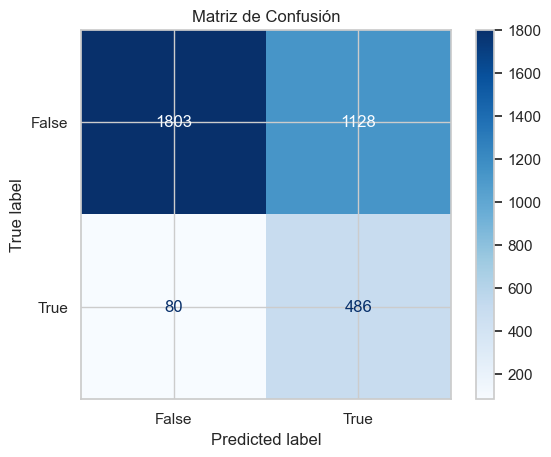

Informe de Clasificación:
              precision    recall  f1-score   support

       False       0.96      0.62      0.75      2931
        True       0.30      0.86      0.45       566

    accuracy                           0.65      3497
   macro avg       0.63      0.74      0.60      3497
weighted avg       0.85      0.65      0.70      3497



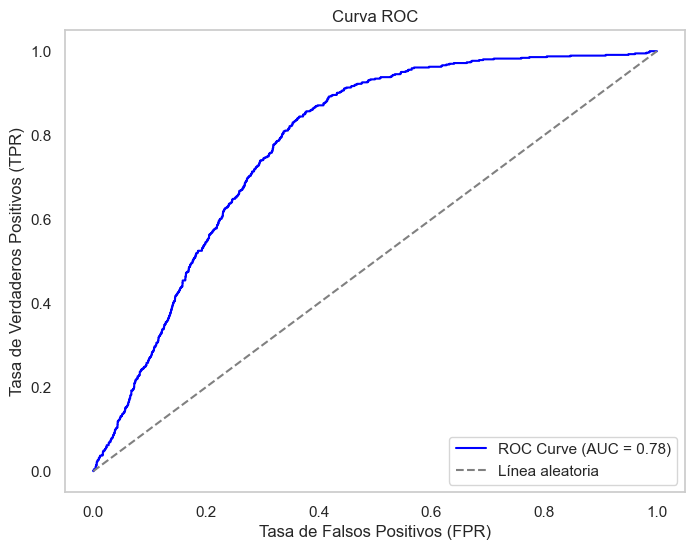

Exactitud (Accuracy): 0.6546
AUC-ROC: 0.7807


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

modelo2 = LogisticRegression(class_weight='balanced',max_iter=2000, solver='lbfgs', random_state=6884)
X_train_stepwise = X_train[variables_seleccionadas]
X_test_stepwise = X_test[variables_seleccionadas]   
modelo2.fit(X_train_stepwise, y_train)

# Realizar predicciones
y_pred = modelo2.predict(X_test_stepwise)
y_prob = modelo2.predict_proba(X_test_stepwise)[:, 1]  # Probabilidades para la clase positiva

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=modelo2.classes_)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión")
plt.show()

# Informe de Clasificación
print("Informe de Clasificación:")
print(classification_report(y_test, y_pred))

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Línea aleatoria")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Métricas Clave
accuracy = modelo2.score(X_test_stepwise, y_test)
print(f"Exactitud (Accuracy): {accuracy:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")


Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END C=0.01, l1_ratio=0.5, penalty=l1, solver=liblinear;, score=0.934 total time=   0.0s
[CV 2/5] END C=0.01, l1_ratio=0.5, penalty=l1, solver=liblinear;, score=0.941 total time=   0.0s
[CV 3/5] END C=0.01, l1_ratio=0.5, penalty=l1, solver=liblinear;, score=0.937 total time=   0.0s
[CV 4/5] END C=0.01, l1_ratio=0.5, penalty=l1, solver=liblinear;, score=0.950 total time=   0.0s
[CV 5/5] END C=0.01, l1_ratio=0.5, penalty=l1, solver=liblinear;, score=0.921 total time=   0.0s
[CV 1/5] END C=0.01, l1_ratio=0.5, penalty=l1, solver=saga;, score=0.896 total time=   5.9s
[CV 2/5] END C=0.01, l1_ratio=0.5, penalty=l1, solver=saga;, score=0.885 total time=   4.4s
[CV 3/5] END C=0.01, l1_ratio=0.5, penalty=l1, solver=saga;, score=0.892 total time=   4.1s
[CV 4/5] END C=0.01, l1_ratio=0.5, penalty=l1, solver=saga;, score=0.899 total time=   5.1s
[CV 5/5] END C=0.01, l1_ratio=0.5, penalty=l1, solver=saga;, score=0.855 total time= 

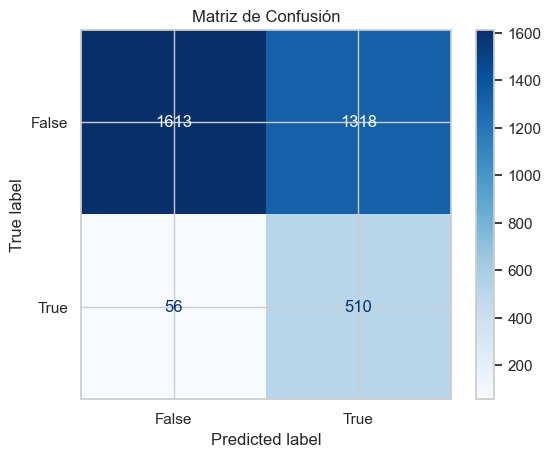

Informe de Clasificación:
              precision    recall  f1-score   support

       False       0.97      0.55      0.70      2931
        True       0.28      0.90      0.43       566

    accuracy                           0.61      3497
   macro avg       0.62      0.73      0.56      3497
weighted avg       0.86      0.61      0.66      3497



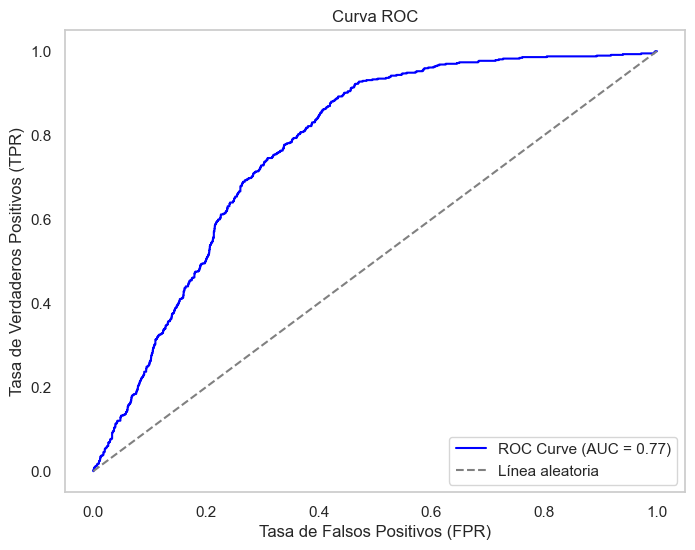

Exactitud (Accuracy): 0.6071
AUC-ROC: 0.7730


In [8]:
# Definir el modelo base
modelo3 = LogisticRegression(class_weight='balanced',random_state=6884, max_iter=2000)

#Hiperparámetros
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Regularización
    'C': [0.01, 0.1, 1, 10, 100],                  # Inverso de la regularización
    'solver': ['liblinear', 'saga'],               # Solvers compatibles con l1 y elasticnet
    'l1_ratio': [0.5]                              # Solo para elasticnet
}

grid_search = GridSearchCV(estimator=modelo3, param_grid=param_grid, cv=5, scoring=make_scorer(recall_score), verbose=3, n_jobs=1)
grid_search.fit(X_train, y_train)

# Resultados del mejor modelo
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor exactitud en validación cruzada:", grid_search.best_score_)

best_model3 = grid_search.best_estimator_
y_pred = best_model3.predict(X_test)
y_prob = best_model3.predict_proba(X_test)[:, 1]

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model3.classes_)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión")
plt.show()

# Informe de Clasificación
print("Informe de Clasificación:")
print(classification_report(y_test, y_pred))

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Línea aleatoria")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Métricas Clave
accuracy = best_model3.score(X_test, y_test)
print(f"Exactitud (Accuracy): {accuracy:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

     Modelo  Accuracy  Precision    Recall  F1-Score       AUC
0  Modelo 1  0.651415   0.299816  0.863958  0.445152  0.780483
1  Modelo 2  0.654561   0.301115  0.858657  0.445872  0.780712
2  Modelo 3  0.607092   0.278993  0.901060  0.426065  0.772960


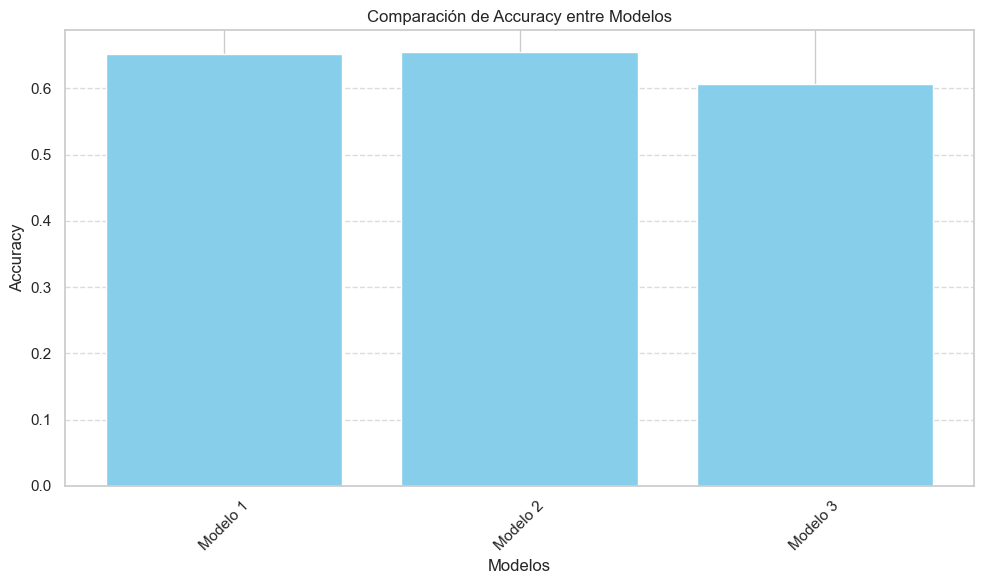

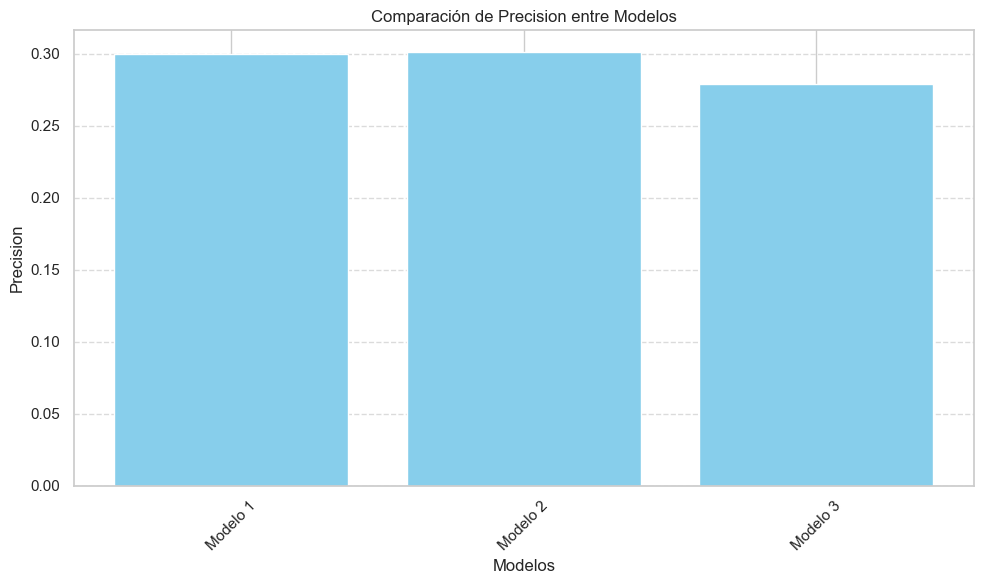

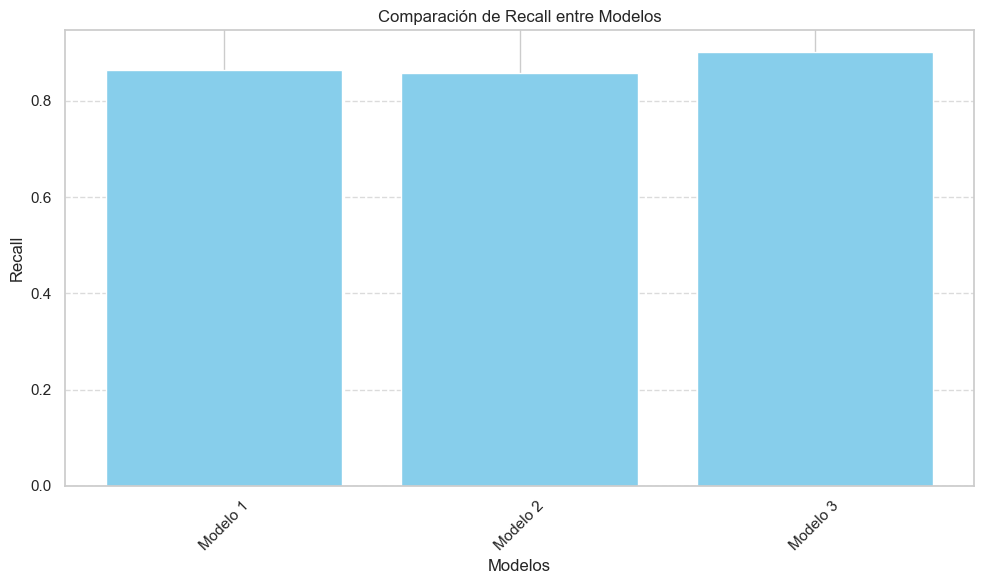

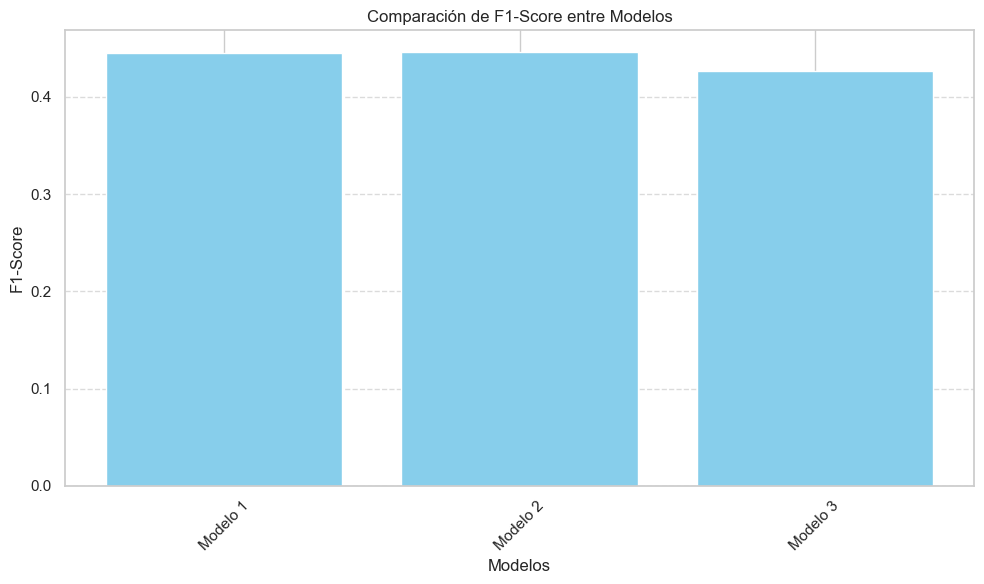

In [9]:
modelos = {
    "Modelo 1": (modelo1, X_train.columns.tolist()),
    "Modelo 2": (modelo2, variables_seleccionadas),
    "Modelo 3": (best_model3, X_train.columns.tolist()),
}

evaluacion = []

for nombre, (modelo, columnas_usadas) in modelos.items():
    X_test_aligned = X_test[columnas_usadas]

    try:
        # Obtener predicciones y probabilidades
        y_pred = modelo.predict(X_test_aligned)
        y_prob = modelo.predict_proba(X_test_aligned)[:, 1]

        # Calcular métricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)

        evaluacion.append({
            'Modelo': nombre,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc
        })
    except Exception as e:
        print(f"Error al evaluar {nombre}: {e}")

df_resultados = pd.DataFrame(evaluacion)
print(df_resultados)

metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for metrica in metricas:
    plt.figure(figsize=(10, 6))
    plt.bar(df_resultados['Modelo'], df_resultados[metrica], color='skyblue')
    plt.title(f"Comparación de {metrica} entre Modelos")
    plt.ylabel(metrica)
    plt.xlabel("Modelos")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



In [12]:
ruta_modelo = "C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/modelos_guardados/modelo2.joblib"
joblib.dump(modelo2, ruta_modelo)

print(f"Modelo guardado exitosamente en '{ruta_modelo}'")

Modelo guardado exitosamente en 'C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/modelos_guardados/modelo2.joblib'


<span style="font-size:30px; font-weight:bold; color:black;">Machine Learning</span>

Entrenando y ajustando hiperparámetros para: Random Forest
Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.956 total time=  10.1s
[CV 2/5] END max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.973 total time=   9.7s
[CV 3/5] END max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.978 total time=   9.0s
[CV 4/5] END max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.975 total time=   9.5s
[CV 5/5] END max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.978 total time=   8.7s
[CV 1/5] END max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=350;, score=0.953 total time=  11.3s
[CV 2/5] END max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=350;, score=0.972 total time=  11.0s
[CV 3/5] END max_depth=25, min_samples_leaf=1, min_sa

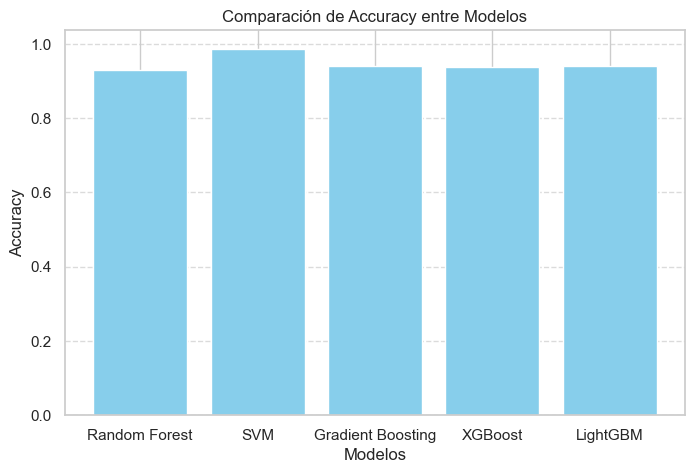

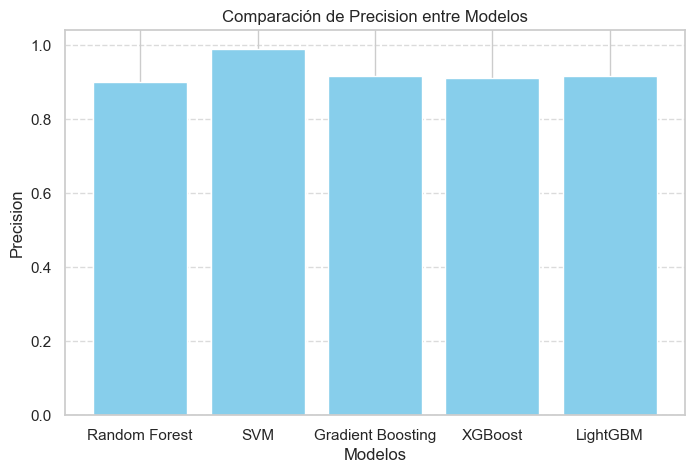

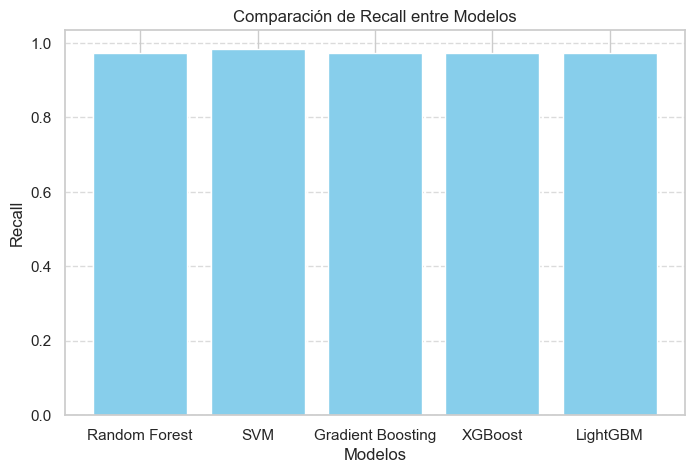

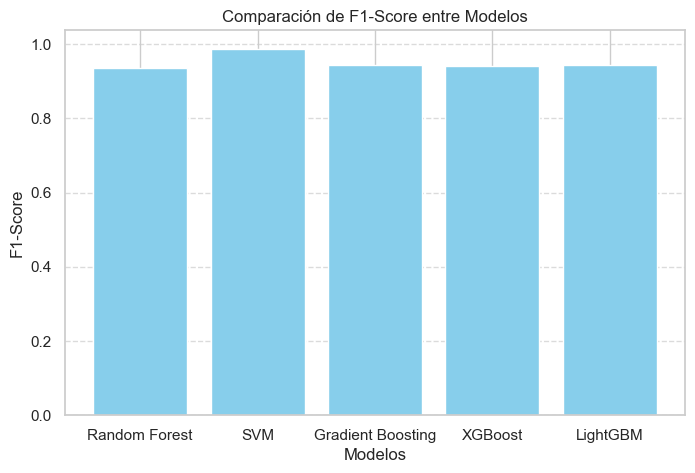

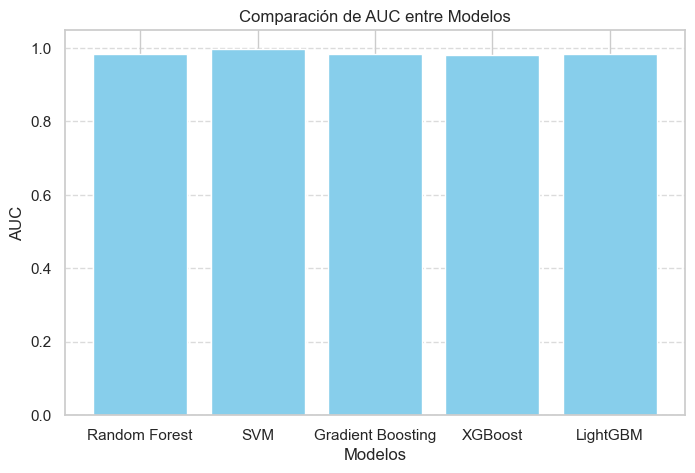

In [6]:
# Random Forest
# Mejor: {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
param_grid_rf = {
    "n_estimators": [300, 350, 400, 450],      # Ampliamos hacia arriba
    "max_depth": [25, 30, 35, 40],             # Probamos mayores profundidades
    "min_samples_split": [2, 3],               # Verificamos si un ligero aumento mejora la estabilidad
    "min_samples_leaf": [1, 2]                 # Exploramos si mantener el valor mínimo o incrementarlo ligeramente
}

# Gradient Boosting
# Mejor: {'learning_rate': 0.3, 'max_depth': 6, 'min_samples_leaf': 5, 'n_estimators': 200}
param_grid_gbm = {
    "learning_rate": [0.2, 0.3, 0.4],          # Afinamos alrededor de 0.3, extendiendo un poco la búsqueda
    "n_estimators": [200, 250, 300],           # Aumentamos el rango en torno al mejor valor 200
    "max_depth": [5, 6, 7],                    # Probamos un poco por debajo y por encima de 6
    "min_samples_leaf": [3, 5, 7]              # Exploramos si valores cercanos a 5 aportan mejoras
}

# XGBoost
# Mejor: {'learning_rate': 0.2, 'max_depth': 12, 'n_estimators': 250, 'reg_alpha': 0.7, 'reg_lambda': 0.5}
param_grid_xgboost = {
    "learning_rate": [0.15, 0.2, 0.25],        # Afinamos en torno a 0.2
    "max_depth": [12, 14, 16],                 # Dado que 12 está en el extremo, exploramos valores mayores
    "n_estimators": [250, 300, 350],           # Ampliamos el rango alrededor de 250
    "reg_alpha": [0.5, 0.7, 0.9],              # Afinamos la regularización L1
    "reg_lambda": [0.5, 0.7, 0.9]              # Afinamos la regularización L2
}

# LightGBM
# Mejor: {'learning_rate': 0.25, 'max_depth': 7, 'min_data_in_leaf': 10, 'n_estimators': 300}
param_grid_lightgbm = {
    "learning_rate": [0.2, 0.25, 0.3],         # Refinamos en torno a 0.25
    "n_estimators": [300, 350, 400],           # Ampliamos el número de árboles
    "max_depth": [7, 8, 9],                    # Probamos profundidades cercanas a 7
    "min_data_in_leaf": [5, 10, 15]            # Dado que 10 podría estar en un extremo, exploramos también menores y mayores
}

# SVM
# Mejor: {'C': 5, 'gamma': 1.25, 'kernel': 'rbf'}
param_grid_svm = {
    "C": [3, 5, 7],                          # Afinamos alrededor de 5
    "gamma": [1, 1.25, 1.5],                   # Exploramos valores en torno a 1.25
    "kernel": ["rbf"]                        # Mantenemos 'rbf' ya que fue el mejor
}

# Crear los modelos
models = {
    'Random Forest': (RandomForestClassifier(random_state=6448, class_weight='balanced'), param_grid_rf),
    'SVM': (SVC(probability=True, class_weight='balanced', random_state=6448), param_grid_svm),
    'Gradient Boosting': (GradientBoostingClassifier(random_state=6448), param_grid_gbm),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=0.91, random_state=6448), param_grid_xgboost),
    'LightGBM': (LGBMClassifier(scale_pos_weight=0.91, random_state=6448), param_grid_lightgbm),
}


# Crear un diccionario para almacenar los modelos entrenados
modelos_entrenados = {}

# Función para probar los modelos y encontrar los mejores hiperparámetros
def train_and_evaluate_models(X_train, X_test, y_train, y_test, models):
    resultados = []

    for model_name, (model, param_grid) in models.items():
        print(f"Entrenando y ajustando hiperparámetros para: {model_name}")
        
        # Búsqueda en cuadrícula para encontrar los mejores hiperparámetros
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring=make_scorer(recall_score), verbose=3, n_jobs=1)
        grid_search.fit(X_train, y_train)

        # Obtener el mejor modelo
        best_model = grid_search.best_estimator_
        
        # Guardar el modelo entrenado
        modelos_entrenados[model_name] = best_model

        # Realizar predicciones
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva

        # Calcular métricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)

        print(f"Mejores hiperparámetros para {model_name}: {grid_search.best_params_}")
        print(f"Desempeño en el conjunto de prueba para {model_name}:\n")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"AUC: {auc:.4f}")
        print(classification_report(y_test, y_pred))

        scores = cross_validate(best_model, X_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], return_train_score=False)

        resultados.append({
            'Modelo': model_name,
            'Mejores Hiperparámetros': grid_search.best_params_,
            'Accuracy': scores['test_accuracy'].mean(),
            'Precision': scores['test_precision'].mean(),
            'Recall': scores['test_recall'].mean(),
            'F1-Score': scores['test_f1'].mean(),
            'AUC': scores['test_roc_auc'].mean()
        })
    
    return resultados

# Entrenar y evaluar los modelos
resultados_modelos = train_and_evaluate_models(X_train, X_test, y_train, y_test, models)

# Convertir los resultados en un DataFrame para visualización
df_resultados = pd.DataFrame(resultados_modelos)

# Mostrar los resultados
print(df_resultados)

# Graficar métricas de los modelos
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
for metrica in metricas:
    plt.figure(figsize=(8, 5))
    plt.bar(df_resultados['Modelo'], df_resultados[metrica], color='skyblue')
    plt.title(f"Comparación de {metrica} entre Modelos")
    plt.ylabel(metrica)
    plt.xlabel("Modelos")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [7]:
import os
import joblib

output_folder = "C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/modelos_guardados"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Guardar cada modelo en la carpeta
for model_name, model in modelos_entrenados.items():
    file_path = os.path.join(output_folder, f"{model_name}.joblib")
    joblib.dump(model, file_path)
    print(f"Modelo {model_name} guardado en {file_path}.")

Modelo Random Forest guardado en C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/modelos_guardados\Random Forest.joblib.
Modelo SVM guardado en C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/modelos_guardados\SVM.joblib.
Modelo Gradient Boosting guardado en C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/modelos_guardados\Gradient Boosting.joblib.
Modelo XGBoost guardado en C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/modelos_guardados\XGBoost.joblib.
Modelo LightGBM guardado en C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/modelos_guardados\LightGBM.joblib.


In [13]:
import os
import joblib
import pickle

# Cargar los modelos guardados en la carpeta
modelos_entrenados = {}
output_folder = "C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/modelos_guardados"

for file_name in os.listdir(output_folder):
    file_path = os.path.join(output_folder, file_name)
    if file_name.endswith(".joblib"):
        model_name = file_name.replace(".joblib", "")
        modelos_entrenados[model_name] = joblib.load(file_path)
        print(f"Modelo {model_name} cargado desde {file_path}.")

Modelo Gradient Boosting cargado desde C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/modelos_guardados\Gradient Boosting.joblib.
Modelo LightGBM cargado desde C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/modelos_guardados\LightGBM.joblib.
Modelo modelo2 cargado desde C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/modelos_guardados\modelo2.joblib.
Modelo Random Forest cargado desde C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/modelos_guardados\Random Forest.joblib.
Modelo SVM cargado desde C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/modelos_guardados\SVM.joblib.
Modelo XGBoost cargado desde C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/modelos_guardados\XGBoost.joblib.



Evaluando modelo: Gradient Boosting
Resultados para Gradient Boosting:
Accuracy: 0.6972
Precision: 0.3054
Recall: 0.6837
F1-Score: 0.4223
AUC-ROC: 0.7625

Reporte de Clasificación:
              precision    recall  f1-score   support

       False       0.92      0.70      0.79      2931
        True       0.31      0.68      0.42       566

    accuracy                           0.70      3497
   macro avg       0.61      0.69      0.61      3497
weighted avg       0.82      0.70      0.73      3497


Evaluando modelo: LightGBM
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
Resultados para LightGBM:
Accuracy: 0.6972
Precision: 0.3067
Recall: 0.6908
F1-Score: 0.4248
AUC-ROC: 0.7631

Reporte de Clasificación:
              precision    recall  f1-score   support

       False       0.92      0.7

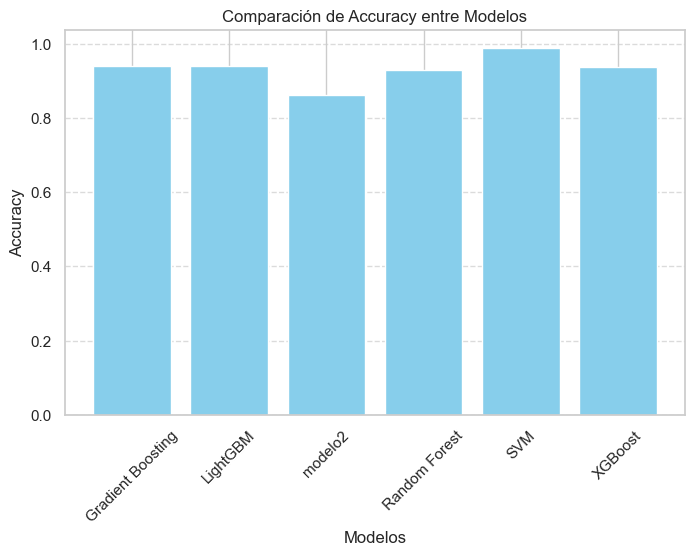

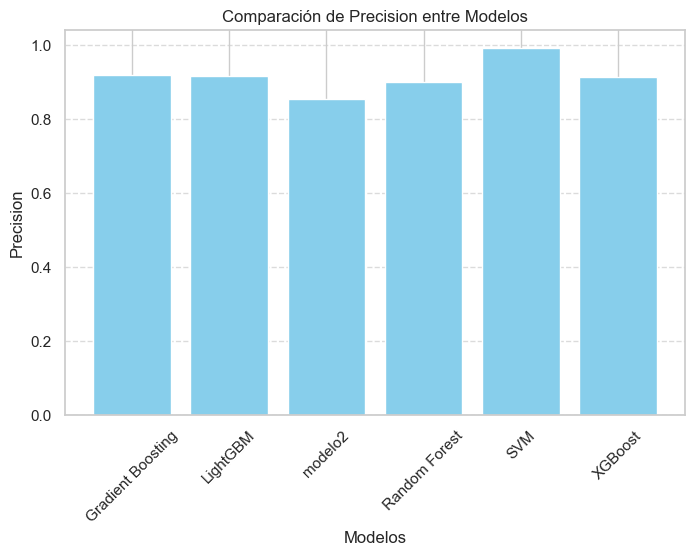

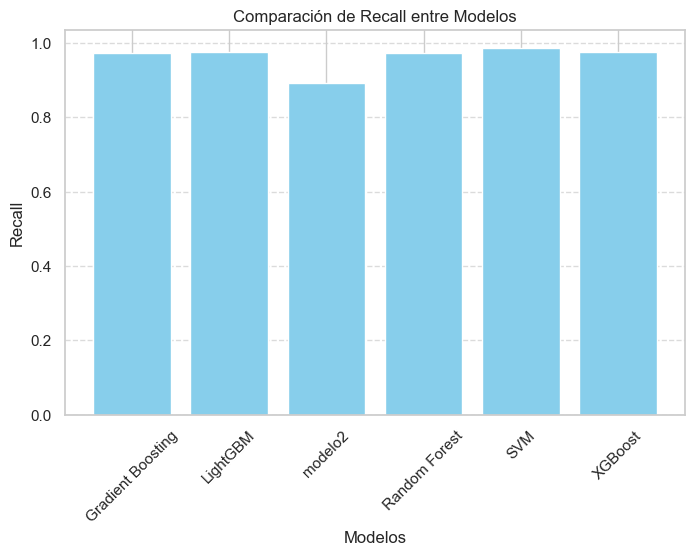

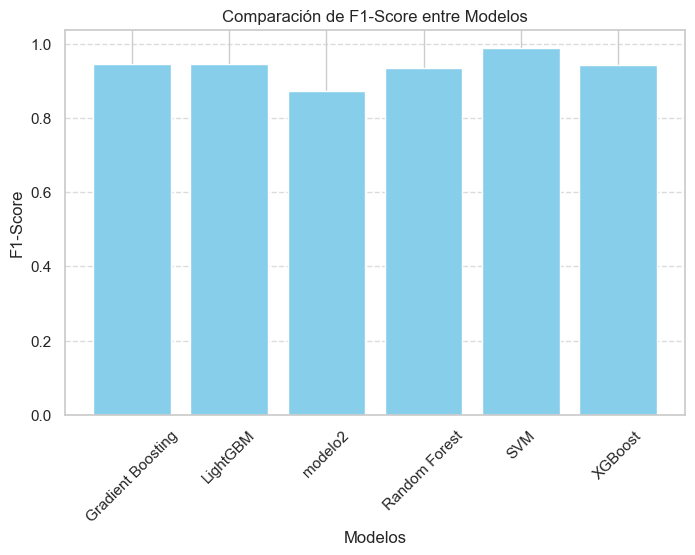

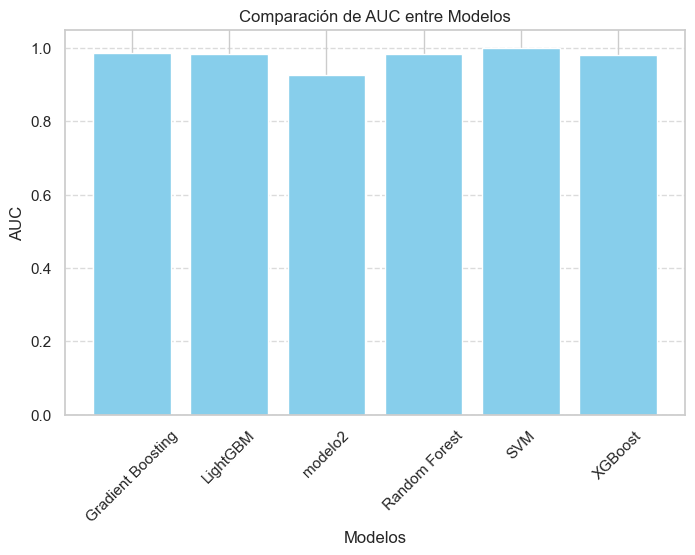

In [15]:
resultados_modelos = []

for model_name, model in modelos_entrenados.items():
    print(f"\nEvaluando modelo: {model_name}")

    # Verificar si el modelo es modelo2 (Regresión Logística con Stepwise)
    if model_name == "modelo2":
        y_pred = model.predict(X_test_stepwise)
        y_prob = model.predict_proba(X_test_stepwise)[:, 1]
    else:
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"Resultados para {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))

    # Validación cruzada
    scores = cross_validate(model, X_train, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

    resultados_modelos.append({
        'Modelo': model_name,
        'Accuracy': scores['test_accuracy'].mean(),
        'Precision': scores['test_precision'].mean(),
        'Recall': scores['test_recall'].mean(),
        'F1-Score': scores['test_f1'].mean(),
        'AUC': scores['test_roc_auc'].mean()
    })

df_resultados = pd.DataFrame(resultados_modelos)

# Mostrar los resultados
print("\nComparación de Modelos:")
print(df_resultados)

df_resultados.to_csv("resultados_modelos.csv", index=False)
print("\nResultados guardados en 'resultados_modelos.csv'.")

metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
for metrica in metricas:
    plt.figure(figsize=(8, 5))
    plt.bar(df_resultados['Modelo'], df_resultados[metrica], color='skyblue')
    plt.title(f"Comparación de {metrica} entre Modelos")
    plt.ylabel(metrica)
    plt.xlabel("Modelos")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

<span style="font-size:30px; font-weight:bold; color:black;">EXPLICABILIDAD</span>

Calculando SHAP para Gradient Boosting...


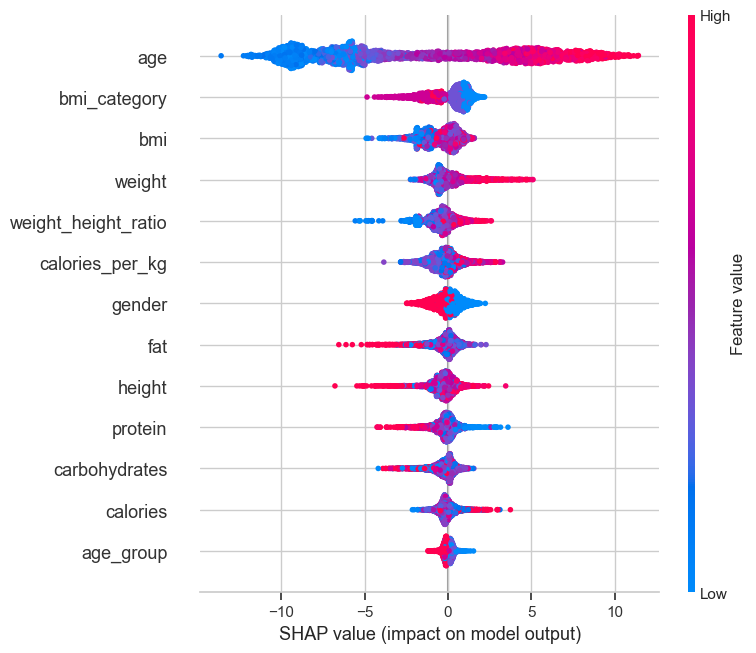

Calculando SHAP para LightGBM...


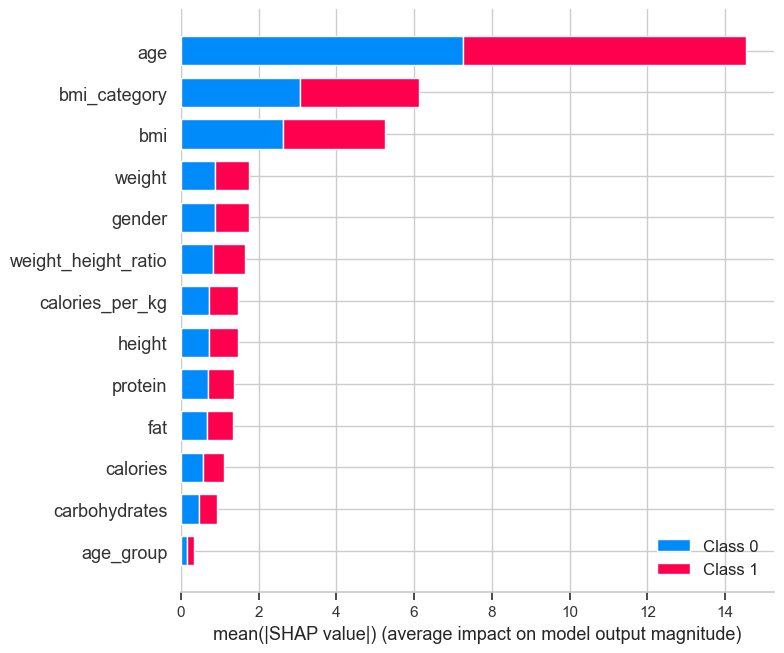

Calculando SHAP para modelo2...


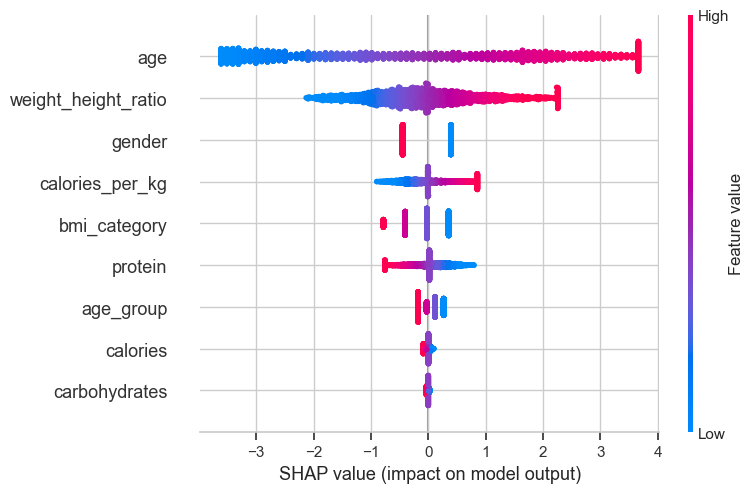

Calculando SHAP para Random Forest...


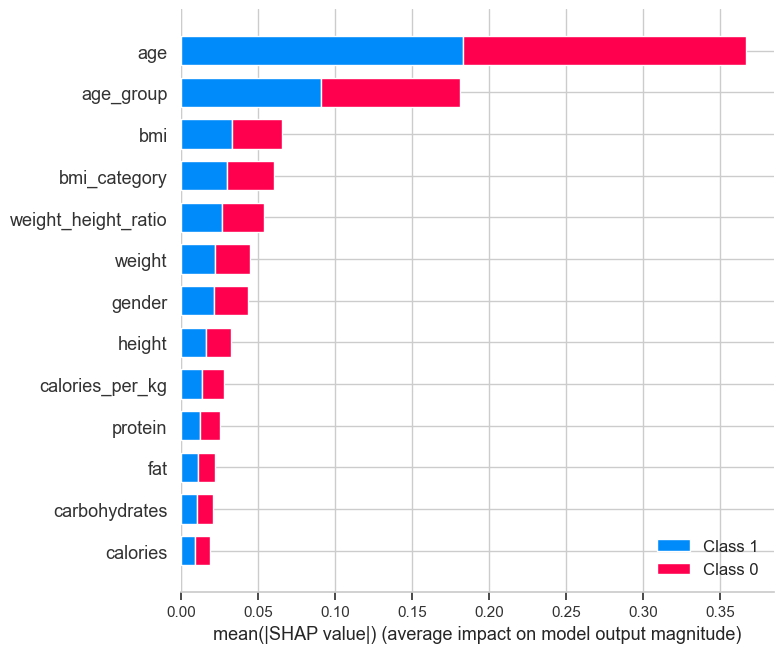

Calculando SHAP para SVM...
Modelo SVM no soportado para SHAP. Saltando...
Calculando SHAP para XGBoost...


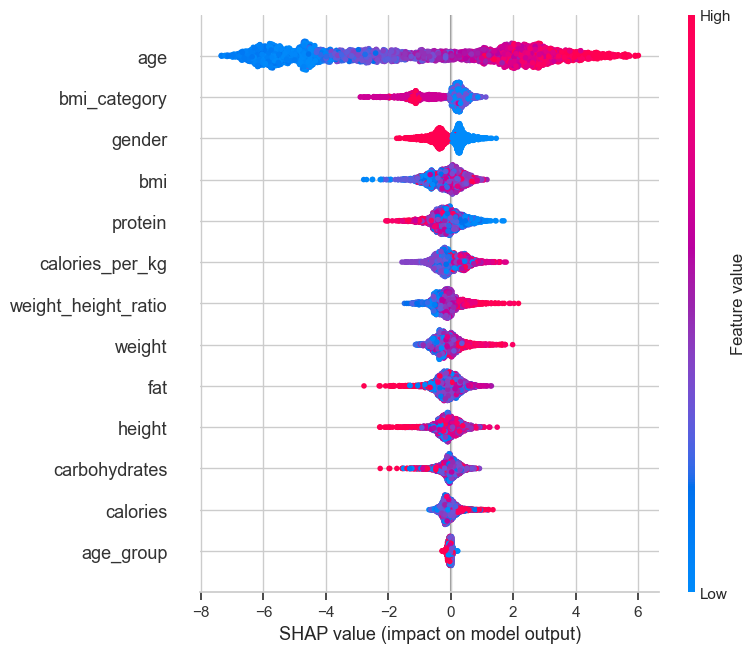

In [21]:
for model_name, model in modelos_entrenados.items():
    print(f"Calculando SHAP para {model_name}...")

    # Identificar el modelo de regresión logística con selección de variables
    if model_name == "modelo2":
        explainer = shap.LinearExplainer(model, X_train_stepwise)  # Usar X_train con selección de variables
        shap_values = explainer.shap_values(X_test_stepwise)  # Evaluar con X_test_stepwise
        feature_names = X_train_stepwise.columns  # Nombres de las variables seleccionadas
    elif isinstance(model, LogisticRegression):
        explainer = shap.LinearExplainer(model, X_train)
        shap_values = explainer.shap_values(X_test)
        feature_names = X_train.columns
    elif isinstance(model, (RandomForestClassifier, GradientBoostingClassifier, XGBClassifier, LGBMClassifier)):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        feature_names = X_train.columns
    else:
        print(f"Modelo {model_name} no soportado para SHAP. Saltando...")
        continue

    # Graficar los valores SHAP
    shap.summary_plot(shap_values, X_test[feature_names], feature_names=feature_names)
    plt.show()


<span style="font-size:30px; font-weight:bold; color:black;">PRODUCTIVIZACIÓN</span>

In [22]:
model_path = "C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/modelos_guardados/SVM.joblib"
model = joblib.load(model_path)
print(f"Modelo cargado correctamente desde {model_path}")


scaler_path = "C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/encoders/scaler.joblib"
scaler = joblib.load(scaler_path)
print(f"Scaler cargado correctamente desde {scaler_path}")

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        
        data = request.get_json(force=True)

        expected_features = [
            'gender', 'age', 
            'weight', 'height', 'bmi', 'calories', 'protein',
            'carbohydrates', 'fat', 'weight_height_ratio', 'calories_per_kg',
            'age_group', 'bmi_category'
        ]
        
        # Verificar que no falte ninguna característica
        missing_features = [feat for feat in expected_features if feat not in data]
        if missing_features:
            return jsonify({'error': f'Faltan las siguientes características: {missing_features}'}), 400

        df = pd.DataFrame([data])
        
        
        numeric_columns = [
            'weight', 'height', 'bmi', 'calories', 'protein',
            'carbohydrates', 'fat', 'weight_height_ratio', 'calories_per_kg'
        ]
        
        # Aplicar el scaler
        df[numeric_columns] = df[numeric_columns].astype(float)
        df[numeric_columns] = scaler.transform(df[numeric_columns])
        
        
        df = df[expected_features]
        
        
        prediction = model.predict(df)[0]

        return jsonify({
            'prediction': int(prediction),
            'message': 'Riesgo de hipertensión' if prediction == 1 else 'Sin riesgo de hipertensión'
        })

    except Exception as e:
        return jsonify({'error': str(e)}), 500

def run_app():
    app.run(host="0.0.0.0", port=5000, debug=True, use_reloader=False)

thread = threading.Thread(target=run_app)
thread.start()


Modelo cargado correctamente desde C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/modelos_guardados/SVM.joblib
Scaler cargado correctamente desde C:/Users/juand/OneDrive/Desktop/Tareas Master/TFM/encoders/scaler.joblib
 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.18.18:5000
Press CTRL+C to quit
127.0.0.1 - - [15/Feb/2025 20:18:28] "POST /predict HTTP/1.1" 200 -


In [27]:
url = "http://127.0.0.1:5000/predict"

dato_no_hipertenso = {
    "gender": 1.0,
    "age": 35,
    "weight": 70,
    "height": 175,
    "bmi": 22.9,
    "calories": 2000,
    "protein": 90,
    "carbohydrates": 250,
    "fat": 70,
    "weight_height_ratio": 0.4,
    "calories_per_kg": 28.57,
    "age_group": 1,
    "bmi_category": 1
}

dato_hipertenso = {
    "gender": 1.0,               
    "age": 52,                   
    "weight": 98,             
    "height": 163,             
    "bmi": 36,                 
    "calories": 1146,            
    "protein": 61,           
    "carbohydrates": 93,      
    "fat": 57.35,                
    "weight_height_ratio": 0.60,  
    "calories_per_kg": 11,     
    "age_group": 1,        # Grupo de edad (según clases: 'Adult', 'Middle-aged', 'Senior', 'Young')
    "bmi_category": 1     # Categoría de BMI (según tus clases: 'Normal', 'Obese', 'Overweight', 'Underweight')
}

headers = {"Content-Type": "application/json"}
response = requests.post(url, headers=headers, data=json.dumps(dato_hipertenso))

print("Código de estado:", response.status_code)
print("Respuesta JSON:", response.json())


Código de estado: 200
Respuesta JSON: {'message': 'Riesgo de hipertensión', 'prediction': 1}
